In [470]:
!pip install 'dtreeviz'

In [471]:
# Manipulacion y Visualizacion de datos
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gp
from matplotlib.patches import Patch
from google.colab import drive
from PIL import Image

#Visualización
import dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, precision_recall_curve, roc_auc_score, recall_score, accuracy_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from sklearn.metrics import roc_auc_score

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [472]:
propiedades = pd.read_csv('/content/dataframe_punto1.csv')
coordenadas_bsas = gp.read_file(r'./barrios.geojson.json')

# Clasificacion

## Construccion del Target

### Precio Por Metro Cuadrado

Comenzamos creando y calculando el precio por metro cuadrado de cada propiedad del dataset, variable que llamamos *pxm2*.

In [473]:
pxm2 = []
for indice in propiedades.index:
  precio = propiedades.at[indice, 'precio']
  superficie = propiedades.at[indice, 'superficie_total']
  pxm2.append((precio / superficie).round(0))

propiedades['pxm2'] = pxm2
propiedades.sort_values('pxm2', inplace = True)
propiedades.reset_index(inplace = True, drop = True)

Y para ver como se distribuye, hacemos un BoxPlot.

<Axes: xlabel='pxm2'>

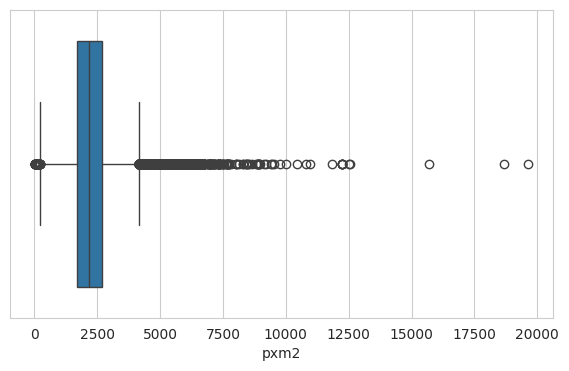

In [474]:
plt.figure(figsize=(7,4))
sns.boxplot(x='pxm2', data=propiedades)

Ademas, para ser mas precisos hacemos 3 BoxPlot, observando la distribucion de *pxm2* en base al *tipo* de la propiedad.

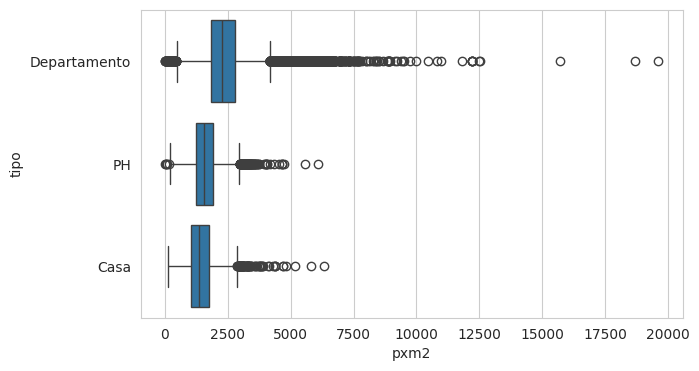

In [475]:
plt.figure(figsize = (7,4))
sns.boxplot(y='tipo', x='pxm2', data=propiedades)
plt.show()

Observamos que el *pxm2* de los departamentos tienen los valores mas elevados, tanto en el rango intercuartilico, como en termino de outliers.

Otro detalle se observa en los outliers por debajo de la caja, que si bien en la distribucion general de la variable se distinguen algunos, en esta distribucion particular hay varios mas. Por otro lado, el *pxm2* de las casas es la unica distribucion que no tiene ningun outlier por debajo de la caja.

### Tipo Precio

Ahora creamos una variable discreta llamada *tipo_precio* que se va a obtener en base al *pxm2* de cada propiedad y va a tener tres valores posibles;

*   Bajo
*   Medio
*   Alto

Hay muchas formas en la cual podemos calcular esta variable; para empezar podemos hacerlo en base a la frecuencia relativa o los cuartiles de su distribucion, y a su vez podemos hacerlo o no por *tipo* de propiedad.

Estas opciones nos dejarian cuatro nuevas variables, y para dejar una sola vamos a crear y estudiar las cuatro.

Para crear la variable en base a la frecuencia relativa general, calculamos los umbrales del indice que dividen en tercios la tabla.

In [476]:
tercio = propiedades.shape[0] / 3
segundo_tercio = 2*tercio

Obtenemos que cada tercio esta dado por un grupo de 24670 registros.

Ademas, para crear la variable en base al rango intercuartilico, calculamos el primer y el tercer cuartil.

In [477]:
primer_cuartil = propiedades['pxm2'].quantile(q = 0.25)
tercer_cuartil = propiedades['pxm2'].quantile(q = 0.75)

print(f'{"Primer cuartil: "}{primer_cuartil}')
print(f'{"Tercer cuartil: "}{tercer_cuartil}')

Primer cuartil: 1707.0
Tercer cuartil: 2688.0


Con los datos ya calculados, imputamos en las nuevas variables dependiendo el umbral que superen.

In [478]:
tp_frecuencia = []
tp_cuartil = []

for indice in propiedades.index:
  precioxm2 = propiedades.at[indice, 'pxm2']

  if indice < tercio - 1:
    tp_frecuencia.append('Bajo')
  elif indice  < segundo_tercio - 1:
    tp_frecuencia.append('Medio')
  else:
    tp_frecuencia.append('Alto')

  if precioxm2 < primer_cuartil:
    tp_cuartil.append('Bajo')
  elif precioxm2 > tercer_cuartil:
    tp_cuartil.append('Alto')
  else:
    tp_cuartil.append('Medio')

propiedades['tp_frecuencia'] = tp_frecuencia
propiedades['tp_cuartil'] = tp_cuartil
propiedades.sample(5)

,id,fecha_inicio,fecha_fin,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,nombre,pxm2,tp_frecuencia,tp_cuartil
4977,/QUMYNIVm1qLNeaUIgZsXg==,2021-05-13,2021-05-18,-34.588776,-58.512229,Villa Devoto,Casa,4.0,3.0,267.0,207.0,305000.0,"Venta casa 4 amb con Parrilla, 2 cocheras/terraza",1142.0,Bajo,Bajo
46703,+aHFdM0G5AsjICjADC6UDg==,2021-08-27,2022-03-25,-34.588788,-58.418352,Palermo,Departamento,3.0,2.0,99.0,90.0,240000.0,VENTA DEPTO 3 AMB. + MONO CON COCHERA PALERMO,2424.0,Medio,Medio
2767,zyb8dhluve0wsfC7W+8Ing==,2021-03-23,2021-06-05,-34.618516,-58.377233,San Telmo,PH,6.0,6.0,415.0,400.0,399833.0,Casa en propiedad horizontal con 6 deptos. y á...,963.0,Bajo,Bajo
53335,Jh7Zfcc4j1hYVkXDpRLACw==,2021-07-15,2022-01-28,-34.581372,-58.423458,Palermo,Departamento,1.0,1.0,30.0,30.0,78500.0,Excelente monoambiente divisible a estrenar c/...,2617.0,Alto,Medio
45813,KhWOA6g3lZUgVDxPCihj4g==,2021-12-31,2022-02-09,-34.596987,-58.379815,Retiro,Departamento,1.0,1.0,25.0,25.0,60000.0,EXCELENTE MONOAMBIENTE. UBICACION PRIVILEGIADA...,2400.0,Medio,Medio


Ahora creamos las variables en base a la frecuencia relativa y al rango intercuartilico, dependiendo del *tipo* de propiedad.

In [479]:
propiedades['tp_frecuencia_tipo'] = np.nan
propiedades['tp_cuartil_tipo'] = np.nan

Para ello, volvemos a realizar los calculos de los umbrales anteriores, pero ahora en base a la variable.

In [480]:
tercios_por_tipo = propiedades.groupby('tipo')['pxm2'].count().reset_index()
tercios_por_tipo.rename(columns = {'pxm2': 'cantidad'}, inplace = True)
tercios_por_tipo['primer_tercio'] = tercios_por_tipo['cantidad'] / 3
tercios_por_tipo['segundo_tercio'] = tercios_por_tipo['primer_tercio'] * 2
print(f'{""}{tercios_por_tipo}')

           tipo  cantidad  primer_tercio  segundo_tercio
0          Casa      3210    1070.000000     2140.000000
1  Departamento     63456   21152.000000    42304.000000
2            PH      7345    2448.333333     4896.666667


In [481]:
primer_cuartil_por_tipo = propiedades.groupby('tipo')['pxm2'].quantile(q = 0.25).reset_index()
tercer_cuartil_por_tipo = propiedades.groupby('tipo')['pxm2'].quantile(q = 0.75).reset_index()

primer_cuartil_por_tipo.rename(columns = {'pxm2': 'primer_cuartil'}, inplace = True)
tercer_cuartil_por_tipo.rename(columns = {'pxm2': 'tercer_cuartil'}, inplace = True)

print(f'{""}{primer_cuartil_por_tipo}\n')
print(f'{""}{tercer_cuartil_por_tipo}')

           tipo  primer_cuartil
0          Casa         1021.25
1  Departamento         1849.00
2            PH         1222.00

           tipo  tercer_cuartil
0          Casa          1755.0
1  Departamento          2778.0
2            PH          1917.0


Para poder imputar los valores correspondientes a cada variable, dividimos el dataframe por tipo y ademas nos guardamos una copia de los indices, para poder imputar correctamente.

In [482]:
indices = []

for indice in propiedades.index:
  indices.append(indice)

propiedades['indices'] = indices

In [483]:
casas = propiedades[propiedades['tipo'] == 'Casa'].sort_values('pxm2').reset_index(drop = True)

In [484]:
deptos = propiedades[propiedades['tipo'] == 'Departamento'].sort_values('pxm2').reset_index(drop = True)

In [485]:
phs = propiedades[propiedades['tipo'] == 'PH'].sort_values('pxm2').reset_index(drop = True)

Una vez hechos todos los preparativos, imputamos ambas variables que correspondan a las propiedades que son casas. Cabe destacar que dentro de los dataframes donde guardamos los umbrales, las filas que representan las casas corresponden al indice 0 (se pueden observar en los primeros loc).

In [486]:
primer_tercio = tercios_por_tipo.loc[0, 'primer_tercio']
segundo_tercio = tercios_por_tipo.loc[0, 'segundo_tercio']

primer_cuartil = primer_cuartil_por_tipo.loc[0, 'primer_cuartil']
tercer_cuartil = tercer_cuartil_por_tipo.loc[0, 'tercer_cuartil']

for indice in casas.index:
  id = casas.loc[indice, 'indices']
  precioxm2 = propiedades.at[indice, 'pxm2']

  if indice < primer_tercio - 1:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Bajo'
  elif indice < segundo_tercio - 1:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Medio'
  else:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Alto'

  if precioxm2 < primer_cuartil:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Bajo'
  elif precioxm2 > tercer_cuartil:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Alto'
  else:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Medio'

Ahora imputamos ambas variables que correspondan a las propiedades que son departamentos. Cabe destacar que dentro de los dataframes donde guardamos los umbrales, las filas que representan las casas corresponden al indice 1 (se pueden observar en los primeros `loc`).

In [487]:
primer_tercio = tercios_por_tipo.loc[1, 'primer_tercio']
segundo_tercio = tercios_por_tipo.loc[1, 'segundo_tercio']

primer_cuartil = primer_cuartil_por_tipo.loc[1, 'primer_cuartil']
tercer_cuartil = tercer_cuartil_por_tipo.loc[1, 'tercer_cuartil']

for indice in deptos.index:
  id = deptos.loc[indice, 'indices']
  precioxm2 = propiedades.at[indice, 'pxm2']

  if indice < primer_tercio - 1:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Bajo'
  elif indice < segundo_tercio - 1:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Medio'
  else:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Alto'

  if precioxm2 < primer_cuartil:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Bajo'
  elif precioxm2 > tercer_cuartil:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Alto'
  else:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Medio'

Por ultimo imputamos ambas variables que correspondan a las propiedades que son PH. Cabe destacar que dentro de los dataframes donde guardamos los umbrales, las filas que representan las casas corresponden al indice 2 (se pueden observar en los primeros `loc`).

In [488]:
primer_tercio = tercios_por_tipo.loc[2, 'primer_tercio']
segundo_tercio = tercios_por_tipo.loc[2, 'segundo_tercio']

primer_cuartil = primer_cuartil_por_tipo.loc[2, 'primer_cuartil']
tercer_cuartil = tercer_cuartil_por_tipo.loc[2, 'tercer_cuartil']

for indice in phs.index:
  id = phs.loc[indice, 'indices']
  precioxm2 = propiedades.at[indice, 'pxm2']

  if indice < primer_tercio - 1:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Bajo'
  elif indice < segundo_tercio - 1:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Medio'
  else:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Alto'

  if precioxm2 < primer_cuartil:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Bajo'
  elif precioxm2 > tercer_cuartil:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Alto'
  else:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Medio'

Observamos algunos ejemplos de las cuatro variables creadas.

In [489]:
propiedades.drop('indices', axis = 'columns', inplace = True)
propiedades.sample(5)

,id,fecha_inicio,fecha_fin,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,nombre,pxm2,tp_frecuencia,tp_cuartil,tp_frecuencia_tipo,tp_cuartil_tipo
15906,q/ztkuQlnRetVJi4ZUQYJA==,2021-09-23,2021-09-26,-34.630538,-58.378409,Barracas,Departamento,1.0,1.0,29.0,26.0,47250.0,MONOAMBIENTE EN VENTA PREMIUM en BARRACAS,1629.0,Bajo,Bajo,Bajo,Bajo
68616,v6KJTPS6LLIySWXyPow8Yg==,2021-07-07,9999-12-31,-34.597208,-58.393430,Recoleta,Departamento,1.0,1.0,26.0,26.0,90000.0,Departamento - Recoleta,3462.0,Alto,Alto,Alto,Alto
36748,lXtETuKOzNARm9atQbYnbw==,2021-05-04,2021-06-05,-34.576855,-58.410590,Palermo,Departamento,8.0,4.0,489.0,454.0,1062500.0,"Emblematico edificio en Plaza Alemania, 489 m2...",2173.0,Medio,Medio,Medio,Medio
66936,nNnW1XFEb9YLZyfXIRpLUA==,2021-06-15,2021-06-19,-34.587787,-58.390647,Recoleta,Departamento,3.0,2.0,73.0,65.0,240000.0,3 AMB CON BALCON RECOLETA VISTA AL RIO SEGURIDAD,3288.0,Alto,Alto,Alto,Medio
7210,LUMYfxpvbJs/PKG/lymfUg==,2021-12-16,2022-02-09,-34.638038,-58.463910,Flores,Casa,6.0,3.0,255.0,177.0,325000.0,"Venta triplex 6 amb, sobre Boulevard, Flores",1275.0,Bajo,Bajo,Medio,Bajo


Y para definir con cual nos quedamos, realizamos un PiePlot por cada *tipo_precio* que creamos y comparamos su distribucion.

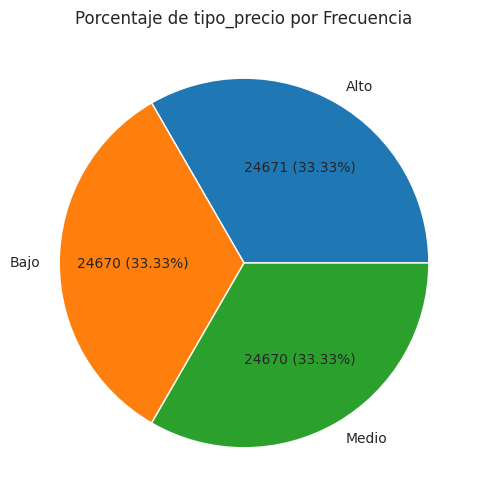

In [490]:
precio_agrupado = propiedades.groupby('tp_frecuencia')['pxm2'].count().reset_index()
precio_agrupado.rename(columns = {'pxm2': 'cantidad'}, inplace = True)

plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
plt.pie(precio_agrupado['cantidad'], labels=['Alto', 'Bajo', 'Medio'], autopct=lambda p: '{:.0f} ({:.2f}%)'.format(p * sum(precio_agrupado['cantidad']) / 100, p))
plt.title("Porcentaje de tipo_precio por Frecuencia")
plt.show()

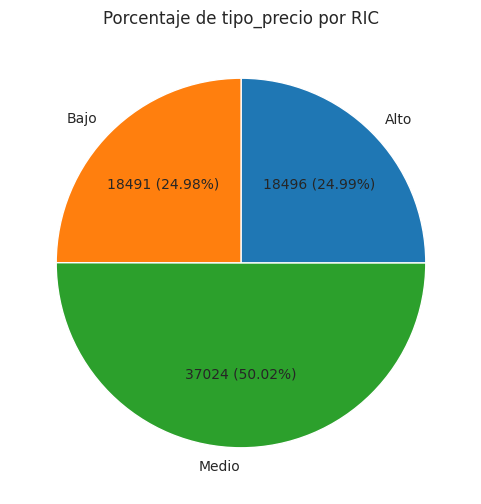

In [491]:
precio_agrupado = propiedades.groupby('tp_cuartil')['pxm2'].count().reset_index()
precio_agrupado.rename(columns = {'pxm2': 'cantidad'}, inplace = True)

plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
plt.pie(precio_agrupado['cantidad'], labels=['Alto', 'Bajo', 'Medio'], autopct=lambda p: '{:.0f} ({:.2f}%)'.format(p * sum(precio_agrupado['cantidad']) / 100, p))
plt.title("Porcentaje de tipo_precio por RIC")
plt.show()

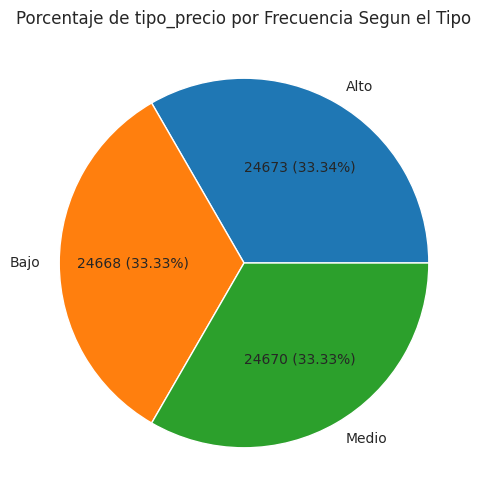

In [492]:
precio_agrupado = propiedades.groupby('tp_frecuencia_tipo')['pxm2'].count().reset_index()
precio_agrupado.rename(columns = {'pxm2': 'cantidad'}, inplace = True)

plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
plt.pie(precio_agrupado['cantidad'], labels=['Alto', 'Bajo', 'Medio'], autopct=lambda p: '{:.0f} ({:.2f}%)'.format(p * sum(precio_agrupado['cantidad']) / 100, p))
plt.title("Porcentaje de tipo_precio por Frecuencia Segun el Tipo")
plt.show()

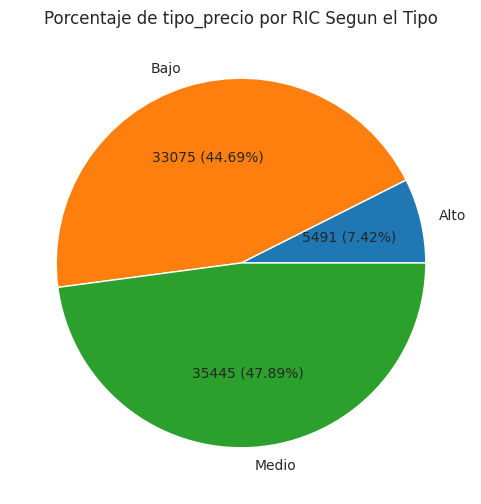

In [493]:
precio_agrupado = propiedades.groupby('tp_cuartil_tipo')['pxm2'].count().reset_index()
precio_agrupado.rename(columns = {'pxm2': 'cantidad'}, inplace = True)
precio_agrupado

plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
plt.pie(precio_agrupado['cantidad'], labels=['Alto', 'Bajo', 'Medio'], autopct=lambda p: '{:.0f} ({:.2f}%)'.format(p * sum(precio_agrupado['cantidad']) / 100, p))
plt.title("Porcentaje de tipo_precio por RIC Segun el Tipo")
plt.show()

Con estos graficos confirmamos lo que pensabamos cuando creamos las variables;

*   *tipo_precio* por frecuencia: Al dividir el *pxm2* en 3 partes iguales, la distribucion es 33,33% para todos los valores de la variable.
*   *tipo_precio* por RIC: Al dividir el *pxm2* por el RIC, los porcentajes quedan datos este rango, es decir, 25%, 50%, y 25% en ese orden para todos los valores de la variable.
*   *tipo_precio* por frecuencia segun el *tipo*: Al dividir cada *pxm2* en 3 partes iguales, incluso teniendo en cuenta el *tipo* de propiedad, la distribucion sigue siendo de 33,33% para todos los valores de la variable.
*   *tipo_precio* por RIC segun el *tipo*: Al tener en cuenta el *tipo* para dividir por el RIC, como las ditribuciones segun el *tipo* son diferentes, en esta variable cambian las proporciones comparadas con el resto. Por esta razon, las propiedades con un *tipo_precio* Alto son solo el 7,42%, el menor porcentaje de entre todas las variables.

Lo que podemos observar de las 4 distribuciones es que, en lo que mas se diferencian, es en la cantidad de propiedades con tipo_precio Alto. Por esta razon, vamos a comparar la distribucion de estas propiedades en las cuatro variables.

<Axes: title={'center': 'tipo_precio Alto por Frecuencia'}, xlabel='pxm2'>

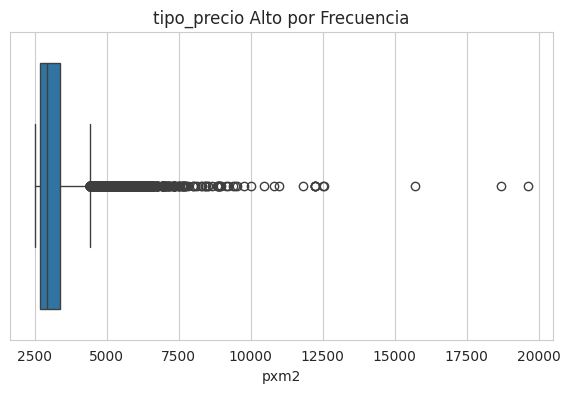

In [494]:
propiedades_caras = propiedades[propiedades['tp_frecuencia'] == 'Alto']
plt.figure(figsize=(7,4))
plt.title("tipo_precio Alto por Frecuencia")
sns.boxplot(x='pxm2', data=propiedades_caras)

<Axes: title={'center': 'tipo_precio Alto por RIC'}, xlabel='pxm2'>

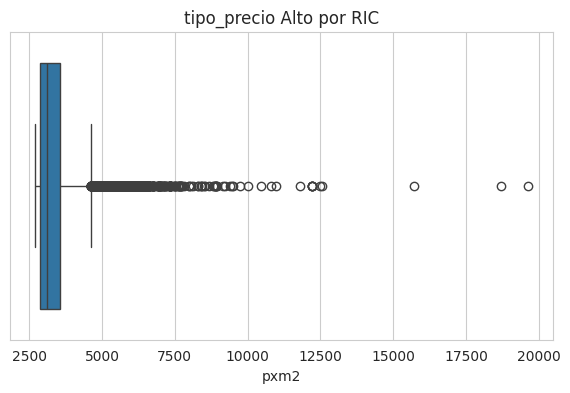

In [495]:
propiedades_caras = propiedades[propiedades['tp_cuartil'] == 'Alto']
plt.figure(figsize=(7,4))
plt.title("tipo_precio Alto por RIC")
sns.boxplot(x='pxm2', data=propiedades_caras)

<Axes: title={'center': 'tipo_precio Alto por Frecuencia Segun el Tipo'}, xlabel='pxm2'>

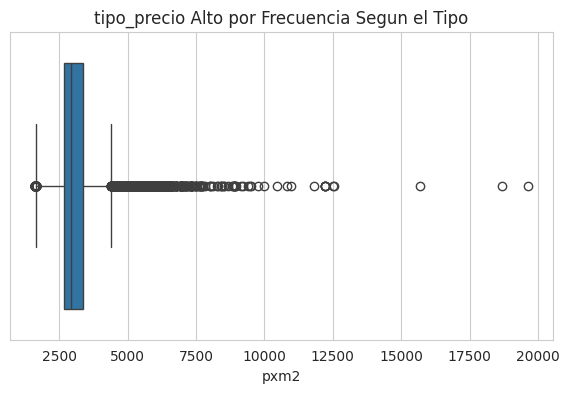

In [496]:
propiedades_caras = propiedades[propiedades['tp_frecuencia_tipo'] == 'Alto']
plt.figure(figsize=(7,4))
plt.title("tipo_precio Alto por Frecuencia Segun el Tipo")
sns.boxplot(x='pxm2', data=propiedades_caras)

<Axes: title={'center': 'tipo_precio Alto por RIC Segun el Tipo'}, xlabel='pxm2'>

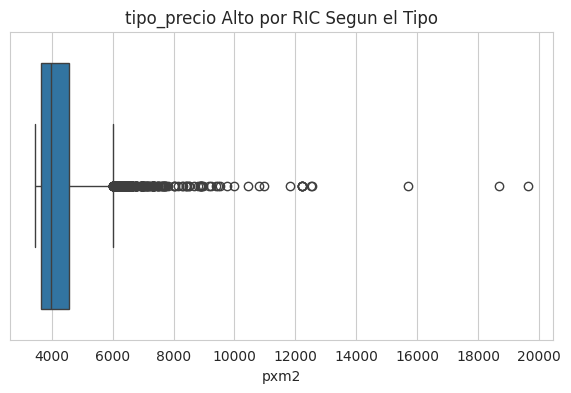

In [497]:
propiedades_caras = propiedades[propiedades['tp_cuartil_tipo'] == 'Alto']
plt.figure(figsize=(7,4))
plt.title("tipo_precio Alto por RIC Segun el Tipo")
sns.boxplot(x='pxm2', data=propiedades_caras)

Observamos y concluimos que la variable que mejor clasifica el *pxm2* es el *tipo_precio* por RIC segun el tipo, que ademas es la variable que tiene los *pxm2* mas altos. Como es la que mejor clasifica estos precios, eligimos que esta sea nuestro *tipo_precio*.

Con esta decision en cuenta, eliminamos los demas tipo_precio creados y nos quedamos con la variable elegida.

In [498]:
columnas_a_eliminar = ['tp_frecuencia', 'tp_cuartil', 'tp_frecuencia_tipo']
propiedades.drop(columnas_a_eliminar, axis = 'columns', inplace = True)
propiedades.rename(columns = {'tp_cuartil_tipo': 'tipo_precio'}, inplace = True)
propiedades.sample(5)

,id,fecha_inicio,fecha_fin,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,nombre,pxm2,tipo_precio
13609,yTLiJFKDvEyaD2LRblw0Hw==,2021-12-23,2022-01-27,-34.608650,-58.408870,Balvanera,Departamento,3.0,2.0,100.0,85.0,155000.0,Departamento - Once,1550.0,Bajo
64234,P8sod9Gn+UIkEacQH9CSng==,2021-06-07,9999-12-31,-34.572444,-58.447409,Belgrano,Departamento,1.0,1.0,40.0,34.0,123500.0,Excelente Ambiente al Frente/ Con balcón terra...,3088.0,Medio
27723,3L2uysbg2Y161wlG83ZEXA==,2021-10-26,2022-01-27,-34.609227,-58.421745,Almagro,Departamento,4.0,3.0,64.0,64.0,125000.0,Departamento - Almagro,1953.0,Bajo
57798,DzqVAekIPiPJaSK65KQhNw==,2021-08-11,2021-08-12,-34.599455,-58.494826,Villa del Parque,Departamento,4.0,3.0,108.0,94.0,299500.0,VENTA DEPARTAMENTO 4 AMB V. DEL PARQUE A ESTRENAR,2773.0,Medio
65909,Jl3kOoyXCieJmI+bhNh1Dg==,2021-04-22,2021-04-25,-34.545803,-58.485239,Saavedra,Departamento,3.0,2.0,64.0,58.0,204900.0,departamento venta saavedra 3 ambientes cochera,3202.0,Medio


### K-means vs tipo_precio

Para completar el analisis de la variable *tipo_precio*, comparamos su distribucion contra los grupos formados por el algortimo de K-means, mas especificamente contra K3.

Primero vamos a comparar como se distribuyen ambas clasificaciones sobre el mapa de CABA.

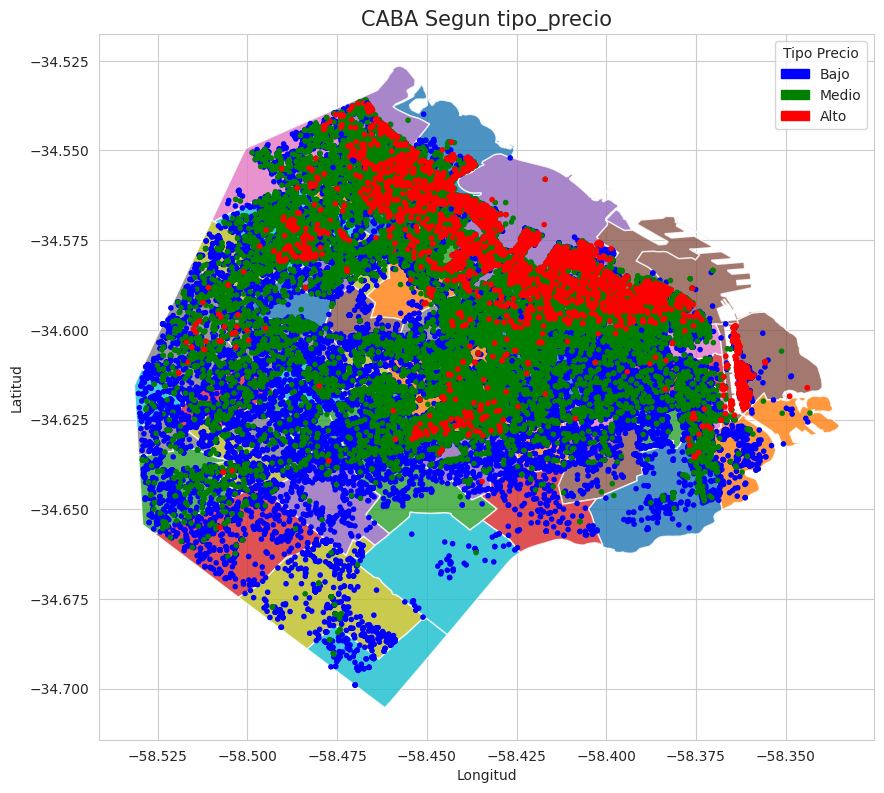

In [499]:
color_map = {'Bajo': 'blue', 'Medio': 'green', 'Alto': 'red'}
colores = propiedades['tipo_precio'].map(color_map)

points = propiedades[['longitud','latitud']]
points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.longitud, points.latitud))

fx, ax = plt.subplots(figsize=(10,10))
coordenadas_bsas.plot(ax=ax, column='BARRIO', alpha=0.8)
points.plot(ax=ax, c=colores, marker='.', label = 'tipo_precio')

legend_elements = [Patch(facecolor='blue', edgecolor='blue', label='Bajo'),
                   Patch(facecolor='green', edgecolor='green', label='Medio'),
                   Patch(facecolor='red', edgecolor='red', label='Alto')]
ax.legend(handles=legend_elements, title='Tipo Precio', loc='upper right')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

plt.title('CABA Segun tipo_precio', fontsize = 15)

plt.savefig('caba_tipo_precio.png', bbox_inches = 'tight')
plt.show()

Si alguien quiere descargar el grafico localmente, ejecute las siguientes lineas en un bloque de codigo abajo de este texto.
```
from google.colab import files
files.download('caba_tipo_precio.png')
```

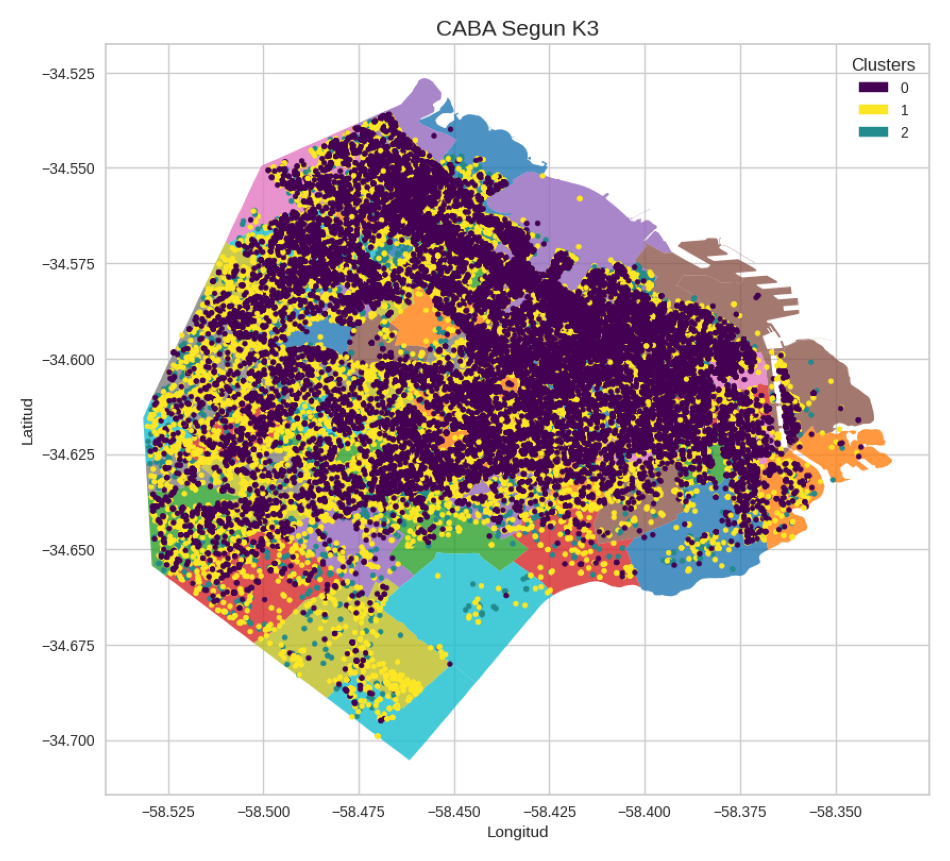

In [500]:
img = Image.open('caba_k3.png')

plt.figure(figsize=(12, 12))
plt.axis('off')

plt.imshow(img)

Por como se distribuye K3 en el mapa de CABA, podemos inferir que la mayoria de propiedades con *tipo_precio*: <font color='red'>Alto</font>  forman parte del <font color='#FDE726'>cluster 0</font> o del <font color='violet'>cluster 1</font>, lo cual tiene sentido ya que estas propiedades son la minoria dentro de la variable, y estos dos clusters son la mayoria.

Y ahora vamos a comparar como se distribuyen ambas clasificaciones en un ScatterPlot de ejes *ambientes* y *superficie_total*, debido a que son las variables que forman los clusters en K-means.

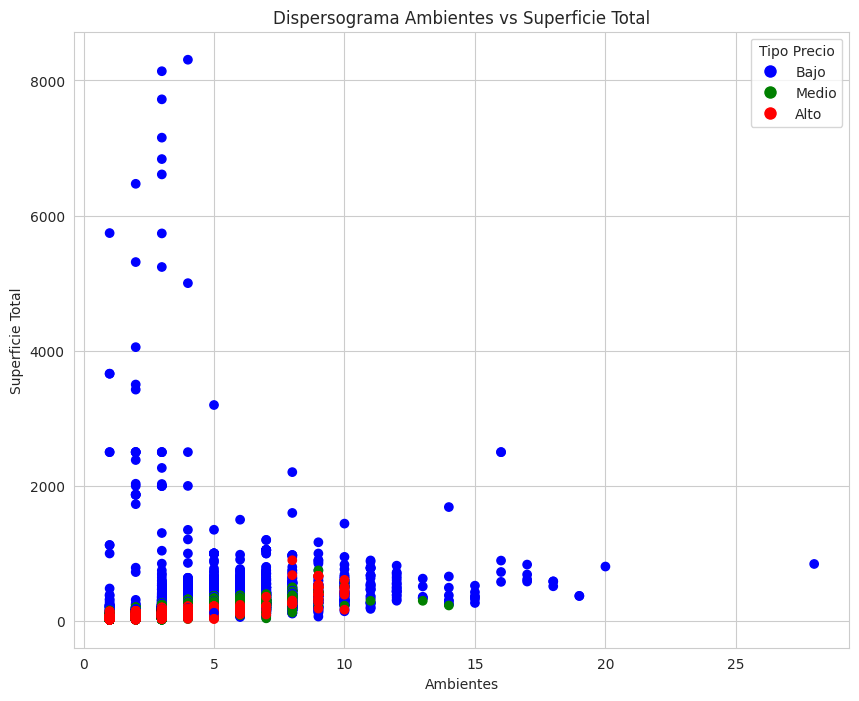

In [501]:
color_map = {'Bajo': 'blue', 'Medio': 'green', 'Alto': 'red'}
colores = propiedades['tipo_precio'].map(color_map)

plt.figure(figsize=(10, 8))
plt.scatter(propiedades['ambientes'], propiedades['superficie_total'], c = colores)
plt.title("Dispersograma Ambientes vs Superficie Total")

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Bajo'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Medio'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Alto')]
plt.legend(handles=legend_elements, title='Tipo Precio', loc='upper right')

plt.xlabel("Ambientes")
plt.ylabel("Superficie Total")

plt.show()

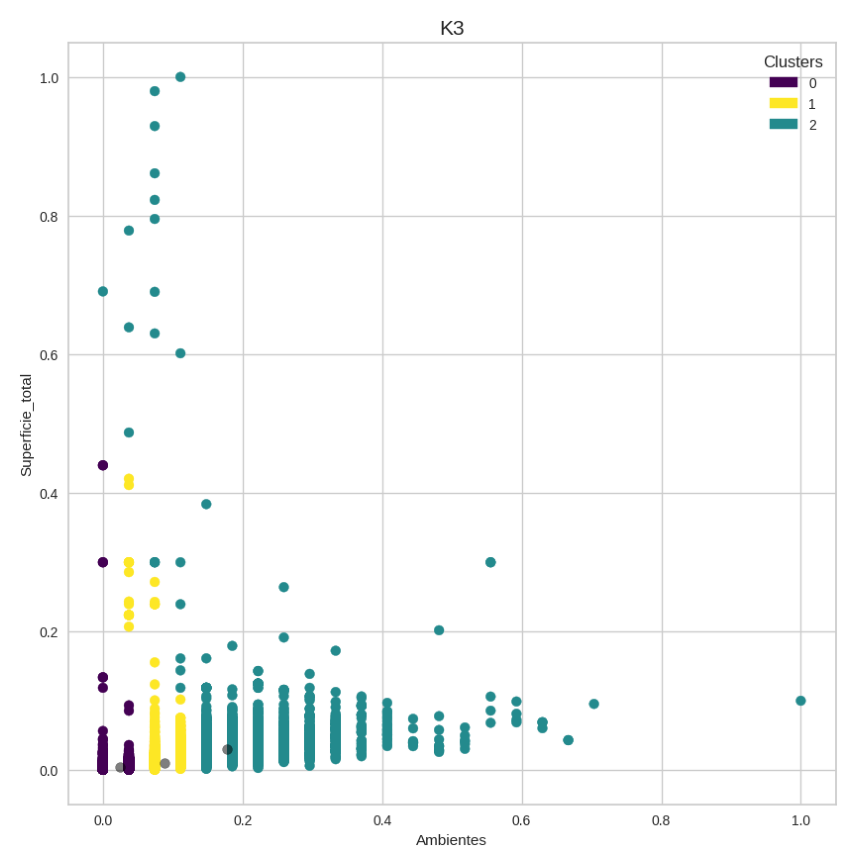

In [502]:
img = Image.open('k3.png')

plt.figure(figsize=(11, 11))
plt.axis('off')

plt.imshow(img)

Lamentablemente, no podemos concluir ninguna relacion entre los clusters formados y la clasificacion obtenida por la variable *tipo_precio*.

## Entrenamiento y Prediccion

Ahora con la variable *tipo_precio* creada, entrenamos 3 modelos disintos para intentar predecirla; Arbol de Decision, Random Forest, y XGBoost. Para esto, aplicamos el siguiente algoritmo:

1.   Realizamos un preprocesamiento inicial sobre el dataframe.
2.   Dividimos el dataframe en train-test.
3.   Creamos un modelo basico y lo entrenamos.
4.   Mostramos las metricas, la matriz de confusion, y la importancia de sus variables.
5.   Graficamos el modelo, o una porción representativa del mismo en caso de ser muy grande, si es posible.
6.   Buscamos los hiperparametros que optimicen el modelo.
7.   Repetimos pasos 3 a 6 para un modelo con los hiperparametros encontrados.



### Preprocesamiento

Arrancamos con el preprocesamiento necesario para entrenar todos los modelos.

Primero, eliminamos varias columnas que consideramos irrelevantes o en su defecto, tienen información directamente relacionada a *tipo_precio*.

In [503]:
columnas_eliminar = ['precio', 'pxm2', 'id', 'fecha_inicio', 'fecha_fin', 'latitud', 'longitud', 'nombre']
propiedades.drop(columnas_eliminar, axis = 'columns', inplace = True)

Y antes de entrenar el modelo, debemos reconvertir las variables categoricas en numeros.

Primero modificamos el target (la variable a predecir) para que quede en una sola columna pero con valores numericos.

In [504]:
propiedades.replace(to_replace = {'Bajo' : 0, 'Medio' : 1, 'Alto' : 2}, inplace = True)

Y para las otras dos variables categoricas, las transformamos mediante un one hot encoding. Al metodo `get_dummies` le pasamos como parámetro `drop_first = True`, ya que la categoría eliminada se la puede deducir por complemento (es decir, si yo tengo una propiedad que NO es PH ni Departamento, se deduce que será una Casa).

In [505]:
propiedades = pd.get_dummies(propiedades, columns=['barrio', 'tipo'], dtype = int, drop_first=True)

Estas serian las columnas resultantes:

In [506]:
propiedades.columns.tolist()

['ambientes',
 'dormitorios',
 'superficie_total',
 'superficie_cubierta',
 'tipo_precio',
 'barrio_Almagro',
 'barrio_Balvanera',
 'barrio_Barracas',
 'barrio_Belgrano',
 'barrio_Boca',
 'barrio_Boedo',
 'barrio_Caballito',
 'barrio_Catalinas',
 'barrio_Chacarita',
 'barrio_Coghlan',
 'barrio_Colegiales',
 'barrio_Constitución',
 'barrio_Flores',
 'barrio_Floresta',
 'barrio_Liniers',
 'barrio_Mataderos',
 'barrio_Monserrat',
 'barrio_Monte Castro',
 'barrio_Nuñez',
 'barrio_Palermo',
 'barrio_Parque Avellaneda',
 'barrio_Parque Chacabuco',
 'barrio_Parque Chas',
 'barrio_Parque Patricios',
 'barrio_Paternal',
 'barrio_Pompeya',
 'barrio_Puerto Madero',
 'barrio_Recoleta',
 'barrio_Retiro',
 'barrio_Saavedra',
 'barrio_San Cristobal',
 'barrio_San Nicolás',
 'barrio_San Telmo',
 'barrio_Velez Sarsfield',
 'barrio_Versalles',
 'barrio_Villa Crespo',
 'barrio_Villa Devoto',
 'barrio_Villa General Mitre',
 'barrio_Villa Lugano',
 'barrio_Villa Luro',
 'barrio_Villa Ortuzar',
 'barrio_Vil

Por ultimo, realizamos las divisiones del dataframe con las cuales vamos a entrenar los modelos.

In [507]:
propiedades_x = propiedades.drop(['tipo_precio'], axis = 'columns', inplace = False)

propiedades_y = propiedades['tipo_precio'].copy()

x_train, x_test, y_train, y_test = train_test_split(propiedades_x,
                                                    propiedades_y,
                                                    test_size = 0.2,
                                                    random_state = 2)

### Arboles de Decision

Arrancaos con el modelo del Arbol de Decision.

#### Arbol de Decision Basico

Ahora si creamos y entrenamos el modelo sin elegir hiperparametros, es decir, un Arbol totalmente por default (salvo por el `random_state` para eliminarle la aleatoriedad entre ejecuciones), y observamos como predice el modelo entrenado..

In [508]:
tree_model = tree.DecisionTreeClassifier(random_state = 2)

modelo = tree_model.fit(X = x_train, y = y_train)
y_pred = modelo.predict(x_test)

resultados = pd.DataFrame(zip(y_test, y_pred), columns = ['test', 'pred'])
resultados.sample(10)

,test,pred
10133,1,2
2384,2,2
2231,0,0
5388,1,1
11655,0,0
9311,0,0
10889,1,1
7126,2,1
12514,1,1
13861,1,1


##### Metricas y Matriz de Confusion

Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

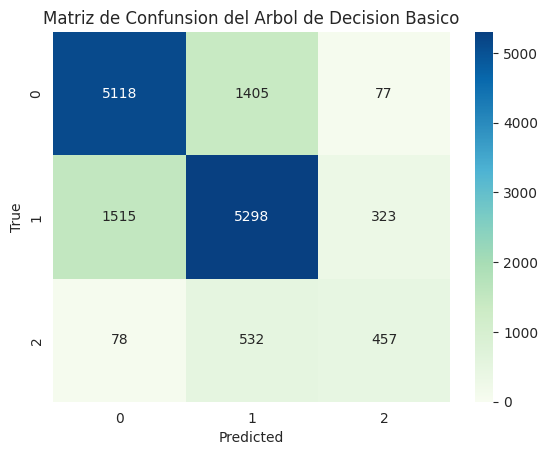

In [509]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confunsion del Arbol de Decision Basico')

plt.show()

Y para respaldar el grafico, calculamos las metricas en el conjunto de evaluacion.

Sin embargo, como el dato a predecir es multiclase y no es binario, las metricas necesitan saber como calcularse cuando hay mas de dos clases en los datos.

Investigamos en la correspondiente documentacion las opciones disponibles para el parametro `average`, y algunas posibilidades para el parametro son:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [510]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred,  average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7345132743362832
Recall: 0.7345132743362832
Precision: 0.7314623255346756
f1 score: 0.7325342409592182


In [511]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      6600
           1       0.73      0.74      0.74      7136
           2       0.53      0.43      0.48      1067

    accuracy                           0.73     14803
   macro avg       0.68      0.65      0.66     14803
weighted avg       0.73      0.73      0.73     14803



Y ademas medimos importancia de las variables, que se calcula como la reduccion total (normalizada) del criterio aportado por esa caracteristica, tambien conocido como **Gini Importance** o  **Mean Decrease in Impurity** (MDI).

In [512]:
sorted(list(zip(propiedades_x.columns.to_list(), modelo.feature_importances_)), key=lambda x: -x[1])

[('superficie_total', 0.28859981088783304),
 ('superficie_cubierta', 0.269210312333918),
 ('tipo_Departamento', 0.1321235856211488),
 ('ambientes', 0.05041763830483423),
 ('dormitorios', 0.029587924743236408),
 ('barrio_Balvanera', 0.0285904812032416),
 ('barrio_Palermo', 0.024975878132313424),
 ('barrio_Recoleta', 0.022166384026273325),
 ('barrio_Puerto Madero', 0.01976315684428955),
 ('barrio_Belgrano', 0.01919484910524413),
 ('barrio_Villa Urquiza', 0.011724992543629714),
 ('barrio_Nuñez', 0.010983954633254646),
 ('barrio_Colegiales', 0.009300139396501672),
 ('barrio_Caballito', 0.00865386993700042),
 ('barrio_Villa Crespo', 0.004677558974002271),
 ('barrio_Saavedra', 0.0046624721015025815),
 ('barrio_Coghlan', 0.004488465444849362),
 ('barrio_Villa Devoto', 0.004071119457126526),
 ('barrio_Almagro', 0.0033027347872165683),
 ('barrio_Villa del Parque', 0.003272957660723264),
 ('barrio_Retiro', 0.003210742841929544),
 ('barrio_Flores', 0.0028463216663666864),
 ('barrio_Chacarita', 0.

Con este array de **Gini Importance**, claramente observamos como los features mas importantes de las propiedades son:

1.   Su cantidad de *superficie_total* y *superficie_cubierta*
2.   Si la propiedad es un Departamento
3.   Su cantidad de *ambientes*
4.   Su cantidad de *dormitorios*
5.   Si la propiedad es del *barrio* Balvanera

Aunque de todas formas, sus coeficientes son bastante bajos por la cantidad de features que se generaron a la hora de hacer el one hot encoding para reconvertir las variables categóricas. Incluso, algunos numeros tienden a 0 donde, intuitivamente por la cantidad que son, notamos que muchos son barrios.

##### Grafico del Arbol

Para terminar, graficamos el Arbol obtenido. Cabe destacar que, por la cantidad de registros, el Arbol completo tarda demasiado en correr y ademas no se visualiza bien, por lo que solo graficamos una parte.

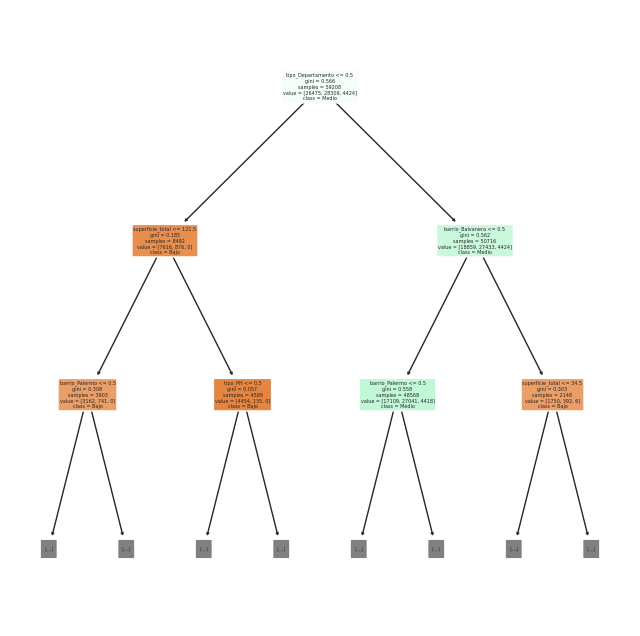

In [513]:
plt.figure(figsize = (8,8))

tree_plot = tree.plot_tree(modelo,
                           max_depth = 2,
                           feature_names = propiedades_x.columns.to_list(),
                           filled = True,
                           rounded = True,
                           class_names = ['Bajo', 'Medio', 'Alto'])

plt.show(tree_plot)

#### Cross Validation

Ya con el Arbol default entrenado, buscamos los mejores hiperparametros con **Random Search Cross Validation**.

Exploramos un espacio de busqueda, usando k-fold CV para medir el desempeño de cada combinacion. Al terminar, nos quedamos con la combinacion con mejor desempeño y entrenamos un unico modelo usando todos los datos de train. La metrica seleccionada a mejorar para buscar hiperparametros optimizados es el F1 Score.

In [514]:
#Cantidad de combinaciones que quiero probar
combinaciones = 40

#Cantidad de splits para el Cross Validation
folds = 20

#Conjunto de parámetros que quiero usar
params_grid = {'criterion' : ['gini', 'entropy'],
               'min_samples_leaf' : list(range(2, 20)),
               'max_depth' : list(range(1, 25))}

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits = folds)

#Clasificador
arbol = DecisionTreeClassifier()

#Metrica que quiero optimizar: F1 Score
scorer_fn = make_scorer(f1_score, average = 'weighted')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = arbol,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = combinaciones)

#Busco los hiperparametros que optimizan F1 Score
randomcv.fit(x_train, y_train);

Cabe destacar que en esta parte del codigo;
```
params_grid = {'criterion' : ['gini', 'entropy'],
               'min_samples_leaf' : list(range(2, 20)),
               'max_depth' : list(range(1, 25))}
```
intentamos agregando otros parametros pero de esta forma obtuvimos mejores resultados. Los parametros que intentamos agregar son:

```
'min_samples_split' : list(range(2, 20))
'ccp_alpha' : np.linspace(0, 0.05, n)
```

Y estos son los hiperparametros obtenidos:

In [515]:
print(f'{"Score: "}{randomcv.best_score_}')
parametros = randomcv.best_params_
parametros

Score: 0.7213853941851671


{'min_samples_leaf': 16, 'max_depth': 24, 'criterion': 'gini'}

Visualizamos los resultados obtenidos en un dataframe.

In [516]:
pd.DataFrame(randomcv.cv_results_).sample(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
29,0.452441,0.235408,0.008173,0.004723,19,20,entropy,"{'min_samples_leaf': 19, 'max_depth': 20, 'cri...",0.724072,0.720414,...,0.730043,0.725204,0.725414,0.714843,0.711318,0.721940,0.716182,0.719291,0.006151,6
30,0.232525,0.006051,0.005833,0.000334,17,11,gini,"{'min_samples_leaf': 17, 'max_depth': 11, 'cri...",0.694588,0.678175,...,0.694052,0.688935,0.686089,0.680758,0.679078,0.677333,0.683101,0.684381,0.005483,24
22,0.068062,0.003064,0.007853,0.000393,5,1,entropy,"{'min_samples_leaf': 5, 'max_depth': 1, 'crite...",0.537876,0.534882,...,0.540741,0.521015,0.521730,0.539341,0.521635,0.515331,0.528372,0.526673,0.009577,36
13,0.379579,0.052676,0.009078,0.001784,14,11,entropy,"{'min_samples_leaf': 14, 'max_depth': 11, 'cri...",0.700116,0.684703,...,0.692942,0.688643,0.687898,0.687612,0.677513,0.678629,0.688393,0.685884,0.006394,23
23,0.374952,0.076165,0.006561,0.001089,11,24,entropy,"{'min_samples_leaf': 11, 'max_depth': 24, 'cri...",0.725099,0.728496,...,0.739963,0.725859,0.722403,0.715313,0.719742,0.723677,0.717566,0.720874,0.007063,2


#### Arbol de Decision Final

Creamos y entrenamos el modelo elegiendo los mejores hiperparametros propuestos segun el **Randomized Search Cross Validation**, y observamos como predice el modelo.

In [517]:
tree_model = tree.DecisionTreeClassifier(criterion = parametros['criterion'],
                                         max_depth = parametros['max_depth'],
                                         min_samples_leaf = parametros['min_samples_leaf'])

modelo = tree_model.fit(X = x_train, y = y_train)
y_pred = modelo.predict(x_test)

resultados = pd.DataFrame(zip(y_test, y_pred), columns = ['test', 'pred'])
resultados.sample(10)

,test,pred
2084,1,1
4184,0,0
1893,2,2
1736,1,1
738,0,0
9051,1,0
5860,1,1
13171,0,1
274,1,1
6867,0,0


Ademas, en la funcion de creacion del arbol;
```
tree_model = tree.DecisionTreeClassifier(criterion = parametros['criterion'],
                                         max_depth = parametros['max_depth'],
                                         min_samples_leaf = parametros['min_samples_leaf'])
```
tambien probamos agregando los parametros extras que probamos en la seccion anterior:
```
ccp_alpha = parametros['ccp_alpha']
min_samples_split = parametros['min_samples_split']
```





##### Metricas y Matriz de Confusion

Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

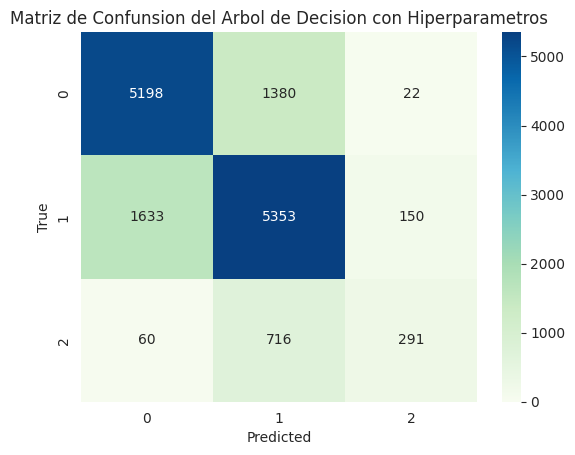

In [518]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confunsion del Arbol de Decision con Hiperparametros')

plt.show()

Como hicimos con el Arbol Basico, para respaldar el grafico calculamos las metricas en el conjunto de evaluacion.

Por las dudas, volvemos a la dejar la documentacion encontrada sobre algunos posibilidades del parametro `average`:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [519]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred,  average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.732419104235628
Recall: 0.732419104235628
Precision: 0.7280406345873123
f1 score: 0.7248449882560873


In [520]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      6600
           1       0.72      0.75      0.73      7136
           2       0.63      0.27      0.38      1067

    accuracy                           0.73     14803
   macro avg       0.70      0.60      0.63     14803
weighted avg       0.73      0.73      0.72     14803



Y ademas medimos importancia de las variables, que se calcula como la reduccion total (normalizada) del criterio aportado por esa caracteristica, tambien conocido como **Gini Importance** o  **Mean Decrease in Impurity** (MDI).

In [521]:
sorted(list(zip(propiedades_x.columns.to_list(),
                modelo.feature_importances_)), key = lambda x: -x[1])

[('tipo_Departamento', 0.2490623863255105),
 ('superficie_total', 0.20035439690794044),
 ('superficie_cubierta', 0.15553189234769654),
 ('barrio_Balvanera', 0.05364970067490298),
 ('barrio_Palermo', 0.04708131238616191),
 ('barrio_Recoleta', 0.04138295461087848),
 ('barrio_Puerto Madero', 0.037254960814325666),
 ('barrio_Belgrano', 0.035739114161748076),
 ('ambientes', 0.032779408946254855),
 ('barrio_Villa Urquiza', 0.02210244755950518),
 ('barrio_Nuñez', 0.02070553822308356),
 ('barrio_Colegiales', 0.017531426356338843),
 ('barrio_Caballito', 0.016190322220650664),
 ('dormitorios', 0.011497897942043313),
 ('barrio_Villa Crespo', 0.008304824844020888),
 ('barrio_Saavedra', 0.00816279587011327),
 ('barrio_Coghlan', 0.007876065038563538),
 ('barrio_Villa Devoto', 0.0068382733120113115),
 ('barrio_Retiro', 0.005755786893024665),
 ('barrio_Almagro', 0.0048144728851369865),
 ('barrio_Chacarita', 0.004635486842010825),
 ('barrio_Villa Pueyrredón', 0.0025600551174647726),
 ('barrio_Villa del

Con este array de **Gini Importance**, claramente observamos como los features mas importantes de las propiedades son:

1.   Su cantidad de *superficie_total*
2.   Si la propiedad es un Departamento
3.   Su cantidad de *superficie_cubierta*
4.   Si la propiedad es del *barrio* Palermo
5.   Si la propiedad es del *barrio* Puerto Madero

Aunque de todas formas, sus coeficientes son bastante bajos por la cantidad de features que se generaron a la hora de hacer el one hot encoding para reconvertir las variables categóricas. Incluso, algunos numeros tienden a 0 donde, intuitivamente por la cantidad que son, notamos que muchos son barrios.

##### Grafico del Arbol

Para terminar, graficamos el nuevo Arbol obtenido con los hiperparametros calculados. Cabe destacar que, por la cantidad de registros, el Arbol completo tarda demasiado en correr y ademas no se visualiza bien, por lo que solo graficamos una parte.

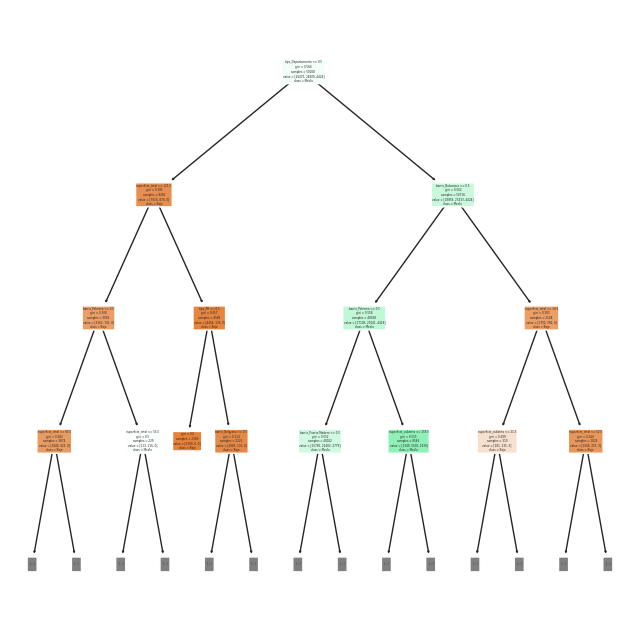

In [522]:
plt.figure(figsize = (8, 8))

tree_plot = tree.plot_tree(modelo,
                           max_depth = 3,
                           feature_names = propiedades_x.columns.to_list(),
                           filled = True,
                           rounded = True,
                           class_names = ['Bajo','Medio','Alto'])

plt.show(tree_plot)

#### Conclusion del Modelo

Nuestra conclusion sobre la clasificacion mediante Arboles de Decisión es que fue muy dificil hasta casi improbable, mejorar las metricas generadas por el modelo creado de forma default. Una vez utilizado el **Random Search CV** y seleccionando 20 folds, logramos encontrar un combinacion de hiperparametros, los cuales casi ni modifican las metricas (lo reducen pero en una medida infima).

 Entonces concluimos que por estar trabajando con big data, los arboles no son tan buenos predictores para este caso, siendo el arbol 100% default uno de los mejores, o quizas el mejor.

### Random Forest

Seguimos con el modelo Random Forest.

#### Random Forest Basico

Primero creamos un modelo 100% por default para obtener sus hiperparametros.

In [523]:
rfc_default = RandomForestClassifier()
rfc_default.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Ahora creamos el Random Forest y observamos como predice el modelo, elegiendo casi todos los hiperparametros por default para probarlo (los hiperparametros que elegimos son el `max_features` que se cambio el default recientemente, el `random_state` para eliminar la aleatoriedad entre ejecuciones, etc).

In [524]:
rfc = RandomForestClassifier(max_features= 'auto',
                             oob_score=True,
                             random_state=2,
                             n_jobs=-1)

modelo = rfc.fit(X = x_train, y = y_train)
y_pred = modelo.predict(x_test)

resultados = pd.DataFrame(zip(y_test, y_pred), columns = ['test' , 'pred'])
resultados.sample(10)

,test,pred
1483,1,1
1553,0,0
481,1,1
13979,1,1
14002,0,1
9511,1,1
1063,0,0
6053,0,0
2161,0,1
1802,0,1


##### Metricas y Matriz de Confusion



Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

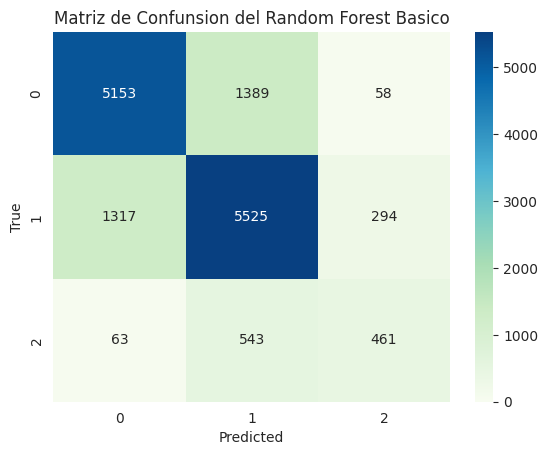

In [525]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confunsion del Random Forest Basico')

plt.show()

Como hicimos con Arbol de Decision, para respaldar el grafico calculamos las metricas en el conjunto de evaluacion.

Por las dudas, volvemos a la dejar la documentacion encontrada sobre algunos posibilidades del parametro `average`:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [526]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred,  average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7524826048773897
Recall: 0.7524826048773897
Precision: 0.7497156467058835
f1 score: 0.7502560476169989


In [527]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      6600
           1       0.74      0.77      0.76      7136
           2       0.57      0.43      0.49      1067

    accuracy                           0.75     14803
   macro avg       0.70      0.66      0.68     14803
weighted avg       0.75      0.75      0.75     14803



Y ademas medimos importancia de las variables, que se calcula como la reduccion total (normalizada) del criterio aportado por esa caracteristica, tambien conocido como **Gini Importance** o  **Mean Decrease in Impurity** (MDI).

In [528]:
sorted(list(zip(propiedades_x.columns.to_list(), modelo.feature_importances_)), key=lambda x: -x[1])

[('superficie_total', 0.329818185393686),
 ('superficie_cubierta', 0.289907719033676),
 ('tipo_Departamento', 0.063937524731785),
 ('barrio_Palermo', 0.03636064483183069),
 ('ambientes', 0.035264754848974615),
 ('tipo_PH', 0.029886358043177914),
 ('barrio_Belgrano', 0.022846149591488202),
 ('barrio_Recoleta', 0.020745607472161542),
 ('barrio_Puerto Madero', 0.020412586778019385),
 ('barrio_Balvanera', 0.02007463441443274),
 ('dormitorios', 0.019685665255440056),
 ('barrio_Nuñez', 0.008951823658313957),
 ('barrio_Villa Urquiza', 0.007888079671588784),
 ('barrio_Flores', 0.007300404995391953),
 ('barrio_Colegiales', 0.005686642761624391),
 ('barrio_Caballito', 0.00541026578706161),
 ('barrio_San Cristobal', 0.004798834034361104),
 ('barrio_Floresta', 0.0043081484767948704),
 ('barrio_Monserrat', 0.004212534301543467),
 ('barrio_San Nicolás', 0.003694987623872467),
 ('barrio_Villa Lugano', 0.0035667656571352264),
 ('barrio_Almagro', 0.003338898846403089),
 ('barrio_Constitución', 0.003165

Con este array de **Gini Importance**, claramente observamos como los features mas importantes de las propiedades son:

1.   Su cantidad de *superficie_total* y *superficie_cubierta*
2.   Si la propiedad es un Departamento
3.   Si la propiedad es del barrio Palermo
4.   Su cantidad de Ambientes
5.   Si la propiedad es un PH

Aunque de todas formas, sus coeficientes son bastante bajos por la cantidad de features que se generaron a la hora de hacer el one hot encoding para reconvertir las variables categóricas. Incluso, algunos numeros tienden a 0 donde, intuitivamente por la cantidad que son, notamos que muchos son barrios.

##### Grafico del Random Forest

Como Random Forest es un ensamble de arboles trabajados en paralelo, no es posible graficar el bosque entero. Por ello, graficamos uno de los `n_estimators = 100` que son por default (uno de los arboles) como ejemplo.

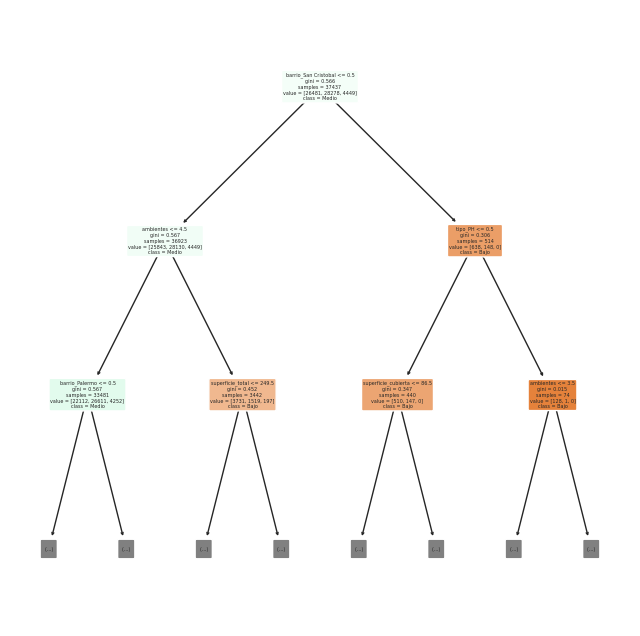

In [529]:
plt.figure(figsize = (8, 8))

tree_plot=tree.plot_tree(modelo.estimators_[68],
                         max_depth = 2,
                         feature_names = propiedades_x.columns.to_list(),
                         filled = True,
                         rounded = True,
                         class_names = ['Bajo', 'Medio', 'Alto'])

plt.show(tree_plot)

#### Cross Validation

Buscaremos los mejores hiperparametros (seleccionando F1 Score, como la metrica a mejorar), pero esta vez con **Grid Search Cross Validation**.

In [530]:
rf_cv = RandomForestClassifier(max_features = 'auto', oob_score = True, random_state = 2, n_jobs = -1)

parametros = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 4, 8],
               "min_samples_split" : [6, 10, 14],
               "n_estimators" : [30, 50, 70] }

#Metrica que quiero optimizar: F1 Score
scorer_fn = make_scorer(f1_score, average = 'weighted')

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator = rf_cv, param_grid = parametros, scoring = scorer_fn, cv = 5, n_jobs = -1)
gs_fit = gs.fit(X = x_train, y = y_train)

Obtenemos la mejor combinacion de hiperparametros.

In [531]:
parametros_seleccionados = gs_fit.best_params_
parametros_seleccionados

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 70}

Vemos cual fue la mejor metrica:



In [532]:
print("F1-Score en entrenamiento con CV: "+str(gs_fit.best_score_))

F1-Score en entrenamiento con CV: 0.7464384037222451


Predecimos utilizando el mejor modelo que obtuvimos en entrenamiento

In [533]:
rf = gs_fit.best_estimator_

y_pred = rf.predict(x_test)

Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

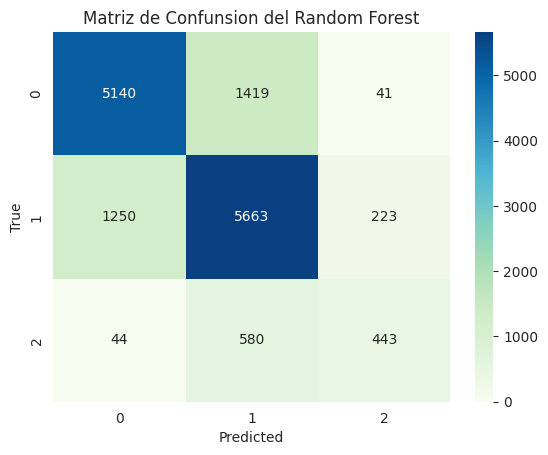

In [534]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confunsion del Random Forest')

plt.show()

Como hicimos con el Random Forest Basico, para respaldar el grafico calculamos las metricas en el conjunto de evaluacion.

Por las dudas, volvemos a la dejar la documentacion encontrada sobre algunos posibilidades del parametro `average`:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [535]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred,  average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7597108694183612
Recall: 0.7597108694183612
Precision: 0.7576450310874553
f1 score: 0.756607977281078


In [536]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      6600
           1       0.74      0.79      0.77      7136
           2       0.63      0.42      0.50      1067

    accuracy                           0.76     14803
   macro avg       0.72      0.66      0.68     14803
weighted avg       0.76      0.76      0.76     14803



Tambien podriamos optimizar hiperparametros teniendo en cuenta mas de una sola metrica. Asi que, ahora buscamos los mejores hiperparametros seleccionando Accuracy, F1 Score, como las metricas a mejorar. Esta optimizacion, se hara tambien con **Grid Search Cross Validation**.

In [537]:
rf_cv = RandomForestClassifier(max_features = 'auto', oob_score = True, random_state = 1, n_jobs = -1)

parametros = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 5, 10],
               "min_samples_split" : [2, 4, 10, 16],
               "n_estimators": [10, 20, 50] }

metricas = {'accuracy' : make_scorer(accuracy_score),
            'f1' : make_scorer(f1_score, average = 'weighted')}

gs_multimetrica = GridSearchCV(estimator = rf_cv,
                               param_grid = parametros,
                               scoring = metricas,
                               refit = False,
                               cv = 5,
                               n_jobs = -1)

gs_multimetrica_fit = gs_multimetrica.fit(X = x_train, y = y_train)

Realizamos un grafico sobre los resultados de las metricas.

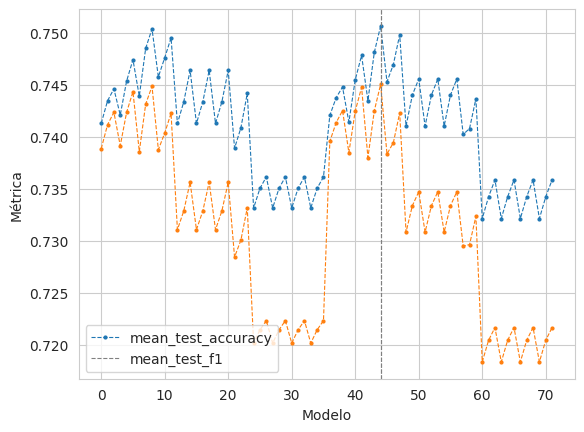

In [538]:
labels=[ key for key in gs_multimetrica_fit.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(gs_multimetrica_fit.cv_results_[k], linestyle = '--',  linewidth = 0.8, marker = 'o', markersize = 2)
    x_linea = np.argmax(gs_multimetrica_fit.cv_results_[k])
    plt.axvline(x_linea, linestyle = '--', linewidth = 0.8, color = 'grey')

plt.xlabel("Modelo", fontsize = 10)
plt.ylabel("Métrica", fontsize = 10)
plt.legend(labels)
plt.show()

En el gráfico observamos como hay 2 modelos (los de la linea punteada en gris), los cuales llegan a las mejores métricas tanto de Accuracy como de F1, en conjunto. Ellos son el modelo num 8 y el modelo num 41.

Sin embargo, también podemos elegir un modelo que maximice una de las dos metricas en particular, aunque en este caso, el modelo que maximiza la Accuracy es justamente el modelo 8.

In [539]:
parametros_max_accuracy = gs_multimetrica_fit.cv_results_['params'][8]
parametros_max_accuracy

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 50}

Y paradójicamente, también el modelo que maximiza el F1-Score es justamente el modelo 41.

In [540]:
parametros_max_f1 = gs_multimetrica_fit.cv_results_['params'][41]
parametros_max_f1

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

De estos 3 modelos con hiperparametros optimizados (los 2 aqui arriba presentes y el anterior CV hecho con una sola métrica a mejorar), deberemos seleccionar uno para crear nuestro Random Forest Optimizado. Notamos que el mejor de los 3, analizando todas sus métricas, fue el primero.

#### Random Forest Final

Creamos el modelo elegiendo los mejores hiperparametros propuestos para el mismo, segun el **Grid Search Cross Validation**, y observamos como predice el modelo.

In [541]:
rfc = RandomForestClassifier(criterion = parametros_seleccionados['criterion'],
                             min_samples_leaf = parametros_seleccionados['min_samples_leaf'],
                             min_samples_split = parametros_seleccionados['min_samples_split'],
                             n_estimators = parametros_seleccionados['n_estimators'],
                             oob_score = True,
                             random_state = 2,
                             n_jobs = -1)

modelo = rfc.fit(X = x_train, y = y_train)
y_pred = modelo.predict(x_test)

resultados = pd.DataFrame(zip(y_test, y_pred), columns = ['test' , 'pred'])
resultados.sample(10)

,test,pred
14480,0,0
6716,1,0
8482,0,0
7569,1,1
7737,1,1
8478,0,1
8892,0,1
11712,2,2
13850,1,1
11247,1,1


##### Metricas y Matriz de Confusion

Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

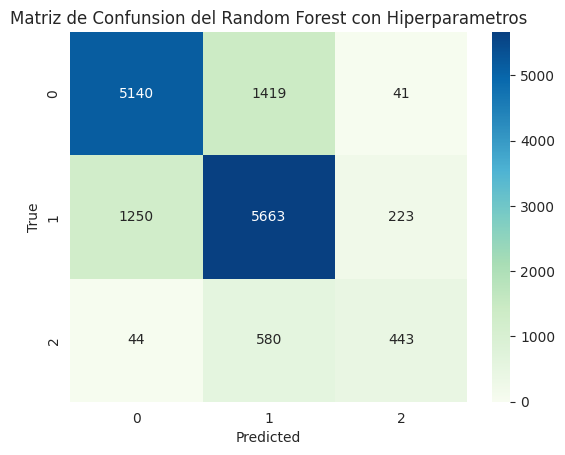

In [542]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confunsion del Random Forest con Hiperparametros')

plt.show()

Repetimos el calculo de las metricas en el conjunto de evaluacion.

Por las dudas, volvemos a la dejar la documentacion encontrada sobre algunos posibilidades del parametro `average`:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [543]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred,  average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7597108694183612
Recall: 0.7597108694183612
Precision: 0.7576450310874553
f1 score: 0.756607977281078


In [544]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      6600
           1       0.74      0.79      0.77      7136
           2       0.63      0.42      0.50      1067

    accuracy                           0.76     14803
   macro avg       0.72      0.66      0.68     14803
weighted avg       0.76      0.76      0.76     14803



Volvemos a calcular **Gini Importance** o tambien, **Mean Decrease in Impurity** (MDI) para las variables.

In [545]:
sorted(list(zip(propiedades_x.columns.to_list(), modelo.feature_importances_)), key = lambda x: -x[1])

[('superficie_total', 0.3093427302942471),
 ('superficie_cubierta', 0.27154100731776293),
 ('tipo_Departamento', 0.06107405320622199),
 ('barrio_Palermo', 0.05036672347670098),
 ('ambientes', 0.03741714720679775),
 ('tipo_PH', 0.03368872695164837),
 ('barrio_Puerto Madero', 0.030414369871869566),
 ('barrio_Belgrano', 0.028959311356676717),
 ('barrio_Recoleta', 0.022813036164380556),
 ('dormitorios', 0.02245643176978652),
 ('barrio_Balvanera', 0.018045290365584343),
 ('barrio_Nuñez', 0.011044080031143908),
 ('barrio_Villa Urquiza', 0.00810688773259093),
 ('barrio_Flores', 0.0076278793820365835),
 ('barrio_Colegiales', 0.005904466222172757),
 ('barrio_Caballito', 0.0053104258125865784),
 ('barrio_San Cristobal', 0.004505522356381925),
 ('barrio_Monserrat', 0.004149761138267372),
 ('barrio_Floresta', 0.004113710887729772),
 ('barrio_Almagro', 0.0037708408391048573),
 ('barrio_San Nicolás', 0.003577922402873082),
 ('barrio_Villa Lugano', 0.003274567763468264),
 ('barrio_Coghlan', 0.0032378

Con este array de **Gini Importance**, claramente observamos como los features mas importantes de las propiedades son:

1.   Su cantidad de *superficie_total* y *superficie_cubierta*
2.   Si la propiedad es un Departamento
3.   Si la propiedad es del barrio Palermo
4.   Su cantidad de Ambientes
5.   Si la propiedad es un PH

Aunque de todas formas, sus coeficientes son bastante bajos por la cantidad de features que se generaron a la hora de hacer el one hot encoding para reconvertir las variables categóricas. Incluso, algunos numeros tienden a 0 donde, intuitivamente por la cantidad que son, notamos que muchos son barrios.

##### Graficamos un árbol del Random Forest con Hiperparametros

Como Random Forest es un ensamble de arboles trabajados en paralelo, no es posible graficar el bosque entero. Por ello, graficamos uno de los `n_estimators=50` que son por default (uno de los arboles) como ejemplo.

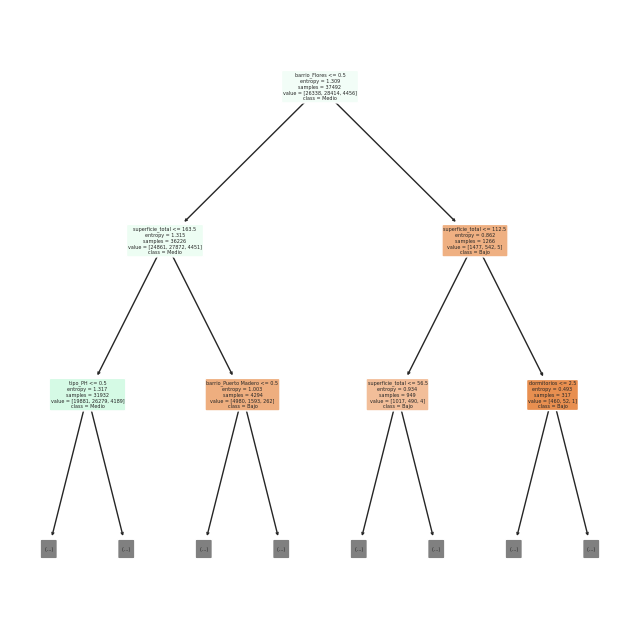

In [546]:
plt.figure(figsize = (8 ,8))

tree_plot=tree.plot_tree(modelo.estimators_[7],
                         max_depth = 2,
                         feature_names = propiedades_x.columns.to_list(),
                         filled = True,
                         rounded = True,
                         class_names = ['Bajo','Medio', 'Alto'])

plt.show(tree_plot)

#### Conclusion del Random Forest

Nuestra conclusión sobre clasificacion mediante Random Forest es que fue dificil mejorar las métricas generadas por el modelo creado de forma default. Sin embargo, utilizando el Grid Search CV y seleccionando F1-Score como la metrica a mejorar, logramos encontrar un combinacion de hiperparametros, los cuales mejoran las metricas aunque en una medida infima.

De esta manera, llegamos a la conclusion de que como los bosques utilizan muchos arboles en paralelo y al estar trabajando con big data, también los Random Forest no son tan buenos predictores para clasificar *tipo_precio*, mencionando que el mejor bosque supera las métricas del mejor árbol, pero en una baja medida.

### Modelo a Eleccion

Ya que entrenamos un Arbol de Decision y un Random Forest, que son modelos basados en **bagging** para reducir la varianza de nuestras predicciones, elegimos entrenar un ultimo modelo basado en **boosting** que reduzca el sesgo.

Como ya anticipamos, de estos modelos elegimos XGBoost que tiene un entrenamiento rapido (algo que debemos considerar debido a la cantidad de registros que tenemos en nuestro dataset), y ofrece mejores rendimientos en comparacion a otros modelos como Gradient Boosting.

#### XGBoost Basico

Primero creamos un modelo 100% por default para obtener sus hiperparametros.

In [547]:
xgb_default = xgb.XGBClassifier()
xgb_default.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

Ahora creamos el XGBoost basico, con casi todos los hiperparametros por default para probarlo y observamos como predice el modelo. El unico hiperparametro que dejamos es el `random_state` para eliminar la aleatoriedad entre ejecuciones.

In [548]:
xgb_model = xgb.XGBClassifier(random_state = 0)
modelo = xgb_model.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

resultados = pd.DataFrame(zip(y_test, y_pred), columns = ['test', 'pred'])
resultados.sample(10)

,test,pred
8572,1,1
2041,0,0
4716,0,1
9242,0,1
6197,0,0
1135,1,1
13477,0,1
3718,1,1
8921,0,0
11393,1,1


##### Metricas y Matriz de Confusion

Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

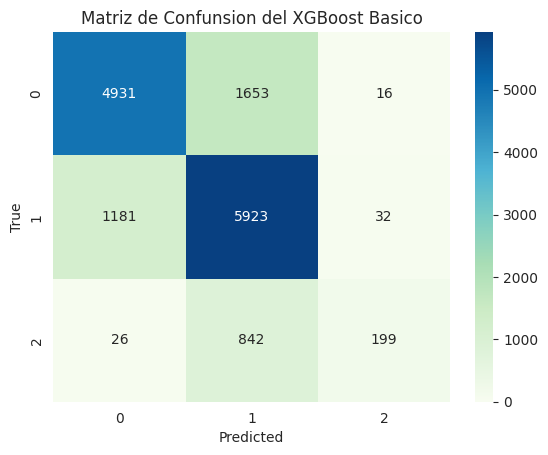

In [549]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confunsion del XGBoost Basico')

plt.show()

Como hicimos con Random Forest, para respaldar el grafico calculamos las metricas en el conjunto de evaluacion.

Por las dudas, volvemos a la dejar la documentacion encontrada sobre algunos posibilidades del parametro `average`:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [550]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7466729716949267
Recall: 0.7466729716949267
Precision: 0.7554393442307735
f1 score: 0.7341648057135932


In [551]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      6600
           1       0.70      0.83      0.76      7136
           2       0.81      0.19      0.30      1067

    accuracy                           0.75     14803
   macro avg       0.77      0.59      0.61     14803
weighted avg       0.76      0.75      0.73     14803



Y ademas medimos importancia de las variables, que se calcula como la reduccion total (normalizada) del criterio aportado por esa caracteristica, tambien conocido como **Gini Importance** o  **Mean Decrease in Impurity** (MDI).

In [552]:
sorted(list(zip(propiedades_x.columns.to_list(), modelo.feature_importances_)), key = lambda x: -x[1])

[('tipo_Departamento', 0.14657283),
 ('barrio_Puerto Madero', 0.10128915),
 ('barrio_Balvanera', 0.07946086),
 ('barrio_Palermo', 0.06807739),
 ('barrio_Belgrano', 0.06276038),
 ('barrio_Recoleta', 0.04945109),
 ('barrio_Nuñez', 0.040625617),
 ('barrio_Villa Urquiza', 0.030543244),
 ('barrio_Colegiales', 0.026707053),
 ('barrio_Villa Lugano', 0.021938989),
 ('barrio_Flores', 0.021549955),
 ('barrio_Caballito', 0.020500675),
 ('barrio_Constitución', 0.01935167),
 ('barrio_San Cristobal', 0.018718509),
 ('barrio_Boca', 0.018186184),
 ('barrio_Monserrat', 0.0180405),
 ('barrio_Floresta', 0.017144334),
 ('barrio_San Nicolás', 0.015516917),
 ('barrio_Coghlan', 0.012660786),
 ('barrio_Boedo', 0.012477356),
 ('barrio_Saavedra', 0.012269651),
 ('barrio_Parque Avellaneda', 0.011746847),
 ('barrio_Villa Devoto', 0.011406188),
 ('barrio_Mataderos', 0.01134576),
 ('tipo_PH', 0.009829942),
 ('barrio_Pompeya', 0.009196646),
 ('barrio_Parque Patricios', 0.008882319),
 ('barrio_Villa Crespo', 0.007956

Con este array de **Gini Importance**, claramente observamos como los features mas importantes de las propiedades son:

1.   Si la propiedad es un Departamento
2.   Si la propiedad es del barrio Puerto Madero
3.   Si la propiedad es del barrio Balvanera
4.   Si la propiedad es del barrio Palermo
5.   Si la propiedad es del barrio Belgrano

Aunque de todas formas, sus coeficientes son bastante bajos por la cantidad de features que se generaron a la hora de hacer el one hot encoding para reconvertir las variables categóricas. Incluso, algunos numeros tienden a 0 donde, intuitivamente por la cantidad que son, notamos que muchos son barrios.

#### Cross Validation

Buscaremos los mejores hiperparametros (seleccionando F1 Score, como la metrica a mejorar), otra
 vez con **Grid Search Cross Validation**.

In [553]:
xgb_cv = xgb.XGBClassifier(random_state = 0)

parametros = {"n_estimators" : [50, 70, 100],
              "learning_rate" : [0.1, 0.3, 0.5],
              "max_depth" : [1, 6, 10, 15],
              "reg_lambda" : [0, 1, 2]}

#Metrica que quiero optimizar: F1 Score
scorer_fn = make_scorer(f1_score, average = 'weighted')

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator = xgb_cv, param_grid = parametros, scoring = scorer_fn, cv = 5, n_jobs = -1)
gs_fit = gs.fit(X = x_train, y = y_train)

Cabe destacar que en esta parte del codigo;
```
parametros = {"n_estimators" : [50, 70, 100],
              "learning_rate" : [0.1, 0.3, 0.5],
              "max_depth" : [1, 6, 10, 15],
              "reg_lambda" : [0, 1, 2]}
```
intentamos agregando otros parametros pero de esta forma obtuvimos mejores resultados. Los parametros que intentamos agregar son:

```
"n_estimators" : [200, 250, 300, 350, 400]
"max_depth" : [10, 15]
"subsample" : [0.1, 0.5, 0.9]
"alpha" : [0, 1, 2]
"gamma" : [0, 1, 2]
"reg_lambda" : [0, 1, 2]
```

Obtenemos la mejor combinacion de hiperparametros.

In [554]:
parametros_seleccionados = gs_fit.best_params_
parametros_seleccionados

{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 100, 'reg_lambda': 2}

Vemos cual fue la mejor metrica:



In [555]:
print("F1-Score en entrenamiento con CV: "+str(gs_fit.best_score_))

F1-Score en entrenamiento con CV: 0.7481261091229452


Predecimos utilizando el mejor modelo que obtuvimos en entrenamiento

In [556]:
xgb_model = gs_fit.best_estimator_

y_pred = xgb_model.predict(x_test)

Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

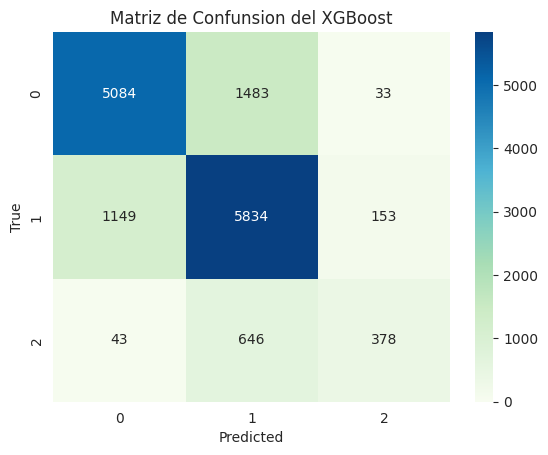

In [557]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confunsion del XGBoost')

plt.show()

Como hicimos con el XGBoost Basico, para respaldar el grafico calculamos las metricas en el conjunto de evaluacion.

Por las dudas, volvemos a la dejar la documentacion encontrada sobre algunos posibilidades del parametro `average`:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [558]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred,  average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7630885631290955
Recall: 0.7630885631290955
Precision: 0.7626621452326849
f1 score: 0.7580196830361695


In [559]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      6600
           1       0.73      0.82      0.77      7136
           2       0.67      0.35      0.46      1067

    accuracy                           0.76     14803
   macro avg       0.74      0.65      0.68     14803
weighted avg       0.76      0.76      0.76     14803



Tambien podriamos optimizar hiperparametros teniendo en cuenta mas de una sola metrica. Asi que, ahora buscamos los mejores hiperparametros seleccionando Accuracy, F1 Score, como las metricas a mejorar. Esta optimizacion, se hara tambien con **Grid Search Cross Validation**.

In [560]:
xgb_cv = xgb.XGBClassifier(random_state = 0)

parametros = {"n_estimators" : [50, 70, 100],
              "learning_rate" : [0.1, 0.3, 0.5],
              "max_depth" : [1, 6, 10, 15],
              "lambda" : [0, 1, 2]}

metricas = {'accuracy' : make_scorer(accuracy_score),
            'f1' : make_scorer(f1_score, average = 'weighted')}

gs_multimetrica = GridSearchCV(estimator = xgb_cv,
                               param_grid = parametros,
                               scoring = metricas,
                               refit = False,
                               cv = 5,
                               n_jobs = -1)

gs_multimetrica_fit = gs_multimetrica.fit(X = x_train, y = y_train)

Realizamos un grafico sobre los resultados de las metricas.

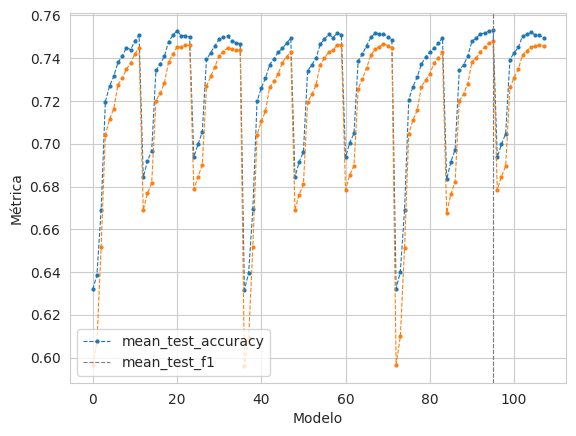

In [561]:
labels = [ key for key in gs_multimetrica_fit.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(gs_multimetrica_fit.cv_results_[k], linestyle = '--',  linewidth = 0.8, marker = 'o', markersize = 2)
    x_linea = np.argmax(gs_multimetrica_fit.cv_results_[k])
    plt.axvline(x_linea, linestyle = '--', linewidth = 0.8, color = 'grey')

plt.xlabel("Modelo", fontsize = 10)
plt.ylabel("Métrica", fontsize = 10)
plt.legend(labels)
plt.show()

En el gráfico observamos que hay varios modelos que llegan a las mejores métricas tanto de Accuracy como de F1.

Buscamos los modelo que consiguen las mejores metricas.

In [562]:
modelo_accuracy = np.argmax(gs_multimetrica_fit.cv_results_['mean_test_accuracy'])
modelo_f1 = np.argmax(gs_multimetrica_fit.cv_results_['mean_test_f1'])

print(f'{"El modelo que mejora Accuracy es: "}{modelo_accuracy}')
print(f'{"El modelo que mejora F1-Score es: "}{modelo_f1}')

El modelo que mejora Accuracy es: 95
El modelo que mejora F1-Score es: 95


Encontramos que hay un solo modelo que mejora ambas variables, y buscamos sus parametros.

In [563]:
parametros_max_accuracy = gs_multimetrica_fit.cv_results_['params'][np.argmax(gs_multimetrica_fit.cv_results_['mean_test_accuracy'])]
parametros_max_accuracy

{'lambda': 2, 'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 100}

Concluimos que todos los modelos encontrados mediante CV son en realidad el mismo modelo que mejor optimiza los hiperparametros.

Para terminar, estudiamos el modelo final.

#### XGBoost Final

Creamos el modelo elegiendo los mejores hiperparametros propuestos para el mismo, segun el **Grid Search Cross Validation**, y observamos como predice el modelo.

In [564]:
xgb_model = xgb.XGBClassifier(n_estimators = parametros_seleccionados['n_estimators'],
                              learning_rate = parametros_seleccionados['learning_rate'],
                              max_depth = parametros_seleccionados['max_depth'],
                              reg_lambda = parametros_seleccionados['reg_lambda'])

modelo = xgb_model.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

resultados = pd.DataFrame(zip(y_test, y_pred), columns = ['test' , 'pred'])
resultados.sample(10)

,test,pred
256,1,1
11210,1,1
3184,1,1
13679,0,0
4356,1,1
495,1,0
10738,0,1
12736,1,1
49,1,1
12992,0,0


##### Metricas y Matriz de Confusion

Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

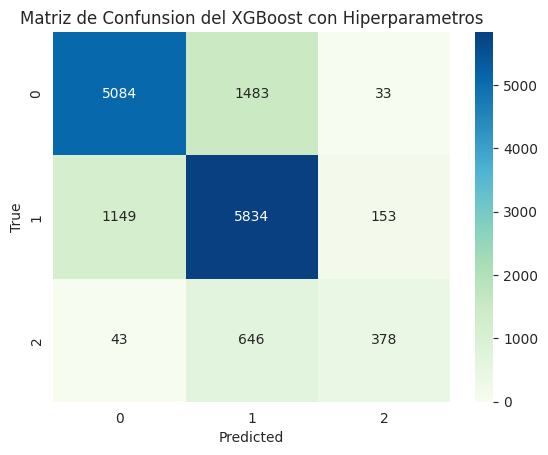

In [565]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confunsion del XGBoost con Hiperparametros')

plt.show()

Repetimos el calculo de las metricas en el conjunto de evaluacion.

Por las dudas, volvemos a la dejar la documentacion encontrada sobre algunos posibilidades del parametro `average`:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [566]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred,  average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7630885631290955
Recall: 0.7630885631290955
Precision: 0.7626621452326849
f1 score: 0.7580196830361695


In [567]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      6600
           1       0.73      0.82      0.77      7136
           2       0.67      0.35      0.46      1067

    accuracy                           0.76     14803
   macro avg       0.74      0.65      0.68     14803
weighted avg       0.76      0.76      0.76     14803



Volvemos a calcular **Gini Importance** o tambien, **Mean Decrease in Impurity** (MDI) para las variables.

In [568]:
sorted(list(zip(propiedades_x.columns.to_list(), modelo.feature_importances_)), key = lambda x: -x[1])

[('barrio_Puerto Madero', 0.15946013),
 ('tipo_Departamento', 0.15520853),
 ('barrio_Balvanera', 0.06465101),
 ('barrio_Villa Lugano', 0.039693527),
 ('barrio_Boca', 0.03453519),
 ('barrio_Palermo', 0.030938264),
 ('barrio_Constitución', 0.030567655),
 ('barrio_Nuñez', 0.028698152),
 ('barrio_Belgrano', 0.025405152),
 ('barrio_Colegiales', 0.02418271),
 ('barrio_Recoleta', 0.02406781),
 ('barrio_Villa Urquiza', 0.01922042),
 ('barrio_Pompeya', 0.018919868),
 ('barrio_San Cristobal', 0.018578036),
 ('barrio_Parque Avellaneda', 0.017859558),
 ('barrio_Floresta', 0.017680073),
 ('barrio_Coghlan', 0.016902013),
 ('barrio_Monserrat', 0.015756577),
 ('tipo_PH', 0.015598468),
 ('barrio_Flores', 0.0139939375),
 ('barrio_Saavedra', 0.013483539),
 ('barrio_San Nicolás', 0.012914778),
 ('barrio_Parque Patricios', 0.011483881),
 ('barrio_Villa Devoto', 0.010536011),
 ('barrio_Villa Crespo', 0.0097394185),
 ('barrio_Caballito', 0.009702206),
 ('barrio_Boedo', 0.009683177),
 ('barrio_Retiro', 0.0095

Con este array de **Gini Importance**, claramente observamos como los features mas importantes de las propiedades son:

1.   Si la propiedad es del barrio Puerto Madero
2.   Si la propiedad es un Departamento
3.   Si la propiedad es del barrio Balvanera
4.   Si la propiedad es del barrio Villa Lugano
5.   Si la propiedad es del barrio Boca

Aunque de todas formas, sus coeficientes son bastante bajos por la cantidad de features que se generaron a la hora de hacer el one hot encoding para reconvertir las variables categóricas. Incluso, algunos numeros tienden a 0 donde, intuitivamente por la cantidad que son, notamos que muchos son barrios.

#### Conclusion del XGBoost


Nuestra conclusión sobre clasificacion mediante XGBoost es que, si bien el modelo default no superaba las metricas de los anteriores modelos, optimizando hiperparametros conseguimos el mejor modelo de clasificacion que realizamos. A pesar de esto, fue dificil mejorar las metricas generadas por el modelo creado de forma default, pero utilizando el Grid Search CV logramos encontrar un combinacion de hiperparametros, los cuales mejoran las metricas aunque en una medida infima.

De esta manera, llegamos a la conclusion de que, de todos los modelos realizados, los XGBoost son buenos predictores para clasificar *tipo_precio*, mencionando que el mejor XGBoost es el mejor modelo por una leve ventaja e las metricas sobre Random Forest.